# 📚 <span style='color:#0D2BA5'>Mission - Segmentez des clients d'un site e-commerce</span>

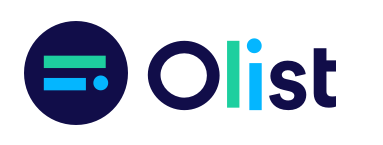

## <span style='background:#99CCFF'>Objectif: Évaluation de la Stabilité Temporelle de la Segmentation par K-Means

<span style='color:#0D2BA5'>***Le processus de simulation vise à évaluer la stabilité temporelle de la segmentation par K-Meansen mesurant l'indice de Rand ajusté (ARI) sur des périodes successives de 2 mois.***
****
<span style='color:#0D2BA5'>***À chaque itération, nous générons des ensembles de données RFM pour la période spécifiée, appliquons la transformation standardisée, et comparons les clusters prédits avec ceux du modèle initial pour déterminer à quel point la segmentation reste cohérente dans le temps.***

<h1 style="color: #1a1a1a; background-color: #e0f7fa; padding: 10px; border-radius: 5px;">1. Chargement et Préparation des Données</h1>

In [1]:
# Chargement des librairies
import pandas as pd
import numpy as np
import seaborn as sns

from datetime import timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.metrics import homogeneity_score, adjusted_rand_score, adjusted_mutual_info_score
from time import time

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# Charger les données
data = pd.read_csv('data_cleaned_for_segmentation.csv')
data['order_purchase_timestamp'] = pd.to_datetime(data['order_purchase_timestamp'])
rfm_log_scaled_df = pd.read_csv('rfm_data.csv')

In [3]:
#Calculer les indicateurs RFM 
date_ref = data['order_purchase_timestamp'].max() + timedelta(days=1)
rfm_data = data.groupby('customer_unique_id').agg(
    Recency=('order_purchase_timestamp', lambda x: (date_ref - x.max()).days),
    Frequency=('order_id', 'count'),
    Monetary=('payment_value', 'sum')
).reset_index()

In [4]:
data['order_purchase_timestamp'] = pd.to_datetime(data['order_purchase_timestamp'])

# Calculer les indicateurs RFM
date_ref = data['order_purchase_timestamp'].max() + timedelta(days=1)
rfm_data = data.groupby('customer_unique_id').agg(
    Recency=('order_purchase_timestamp', lambda x: (date_ref - x.max()).days),
    Frequency=('order_id', 'count'),
    Monetary=('payment_value', 'sum')
).reset_index()

# Charger les données RFM à partir de rfm_data.csv
rfm_log_scaled_df = pd.read_csv('rfm_data.csv')

# Vérifiez la structure de votre DataFrame
print(rfm_log_scaled_df.head())
print(rfm_log_scaled_df.columns)


                 customer_unique_id  recency  frequency  monetary
0  0000366f3b9a7992bf8c76cfdf3221e2      113          1    141.90
1  0000b849f77a49e4a4ce2b2a4ca5be3f      116          1     27.19
2  0000f46a3911fa3c0805444483337064      538          1     86.22
3  0000f6ccb0745a6a4b88665a16c9f078      322          1     43.62
4  0004aac84e0df4da2b147fca70cf8255      289          1    196.89
Index(['customer_unique_id', 'recency', 'frequency', 'monetary'], dtype='object')


<h1 style="color: #1a1a1a; background-color: #e0f7fa; padding: 10px; border-radius: 5px;">2. Standardisation des Données et Initialisation du Modèle K-Means</h1>

### <font color='RoyalBlue'>2.1 Période de référence

- Afin d'avoir une base de comparaison, un premier clustering est effectué sur les données issues des premiers mois de commandes,les résultats les plus pertinents mènent à une période de référence de 10 mois.

In [5]:
# Définir la période de référence de 17 mois
oldest_date = data['order_purchase_timestamp'].min()
one_year_later = oldest_date + pd.DateOffset(months=10)

In [6]:
# Isoler les données de la période de référence
data_ref = data[(data['order_purchase_timestamp'] >= oldest_date) & (data['order_purchase_timestamp'] <= one_year_later)].copy()

In [7]:
# Créer un DataFrame contenant le nombre de commandes par client
df_nb_orders_per_customer = data_ref.groupby(by="customer_unique_id").count()[["order_id"]].reset_index()
df_nb_orders_per_customer.rename(columns={"order_id": "nb_orders_per_customer"}, inplace=True)

In [8]:
# Supprimer la colonne 'order_id' de data_ref
data_ref = data_ref.drop(columns="order_id", errors='ignore')

# Ajouter la récence avant de transformer d'autres colonnes
data_ref['days_since_last_order'] = (data_ref['order_purchase_timestamp'].max() - data_ref['order_purchase_timestamp']).dt.days

# Sélectionner uniquement les colonnes numériques pour le groupby
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
data_ref_numeric = data_ref.select_dtypes(include=numerics)
data_ref_numeric['customer_unique_id'] = data_ref['customer_unique_id']  

# Regrouper par client et calculer les moyennes
data_ref_grouped = data_ref_numeric.groupby(by="customer_unique_id").mean().reset_index().dropna()

# Ajouter le nombre de commandes par client
data_ref_grouped = data_ref_grouped.merge(df_nb_orders_per_customer, on='customer_unique_id', how='left')

# Sélectionner les colonnes utiles pour le clustering
data_ref_final = data_ref_grouped.loc[:, ["review_score", "payment_installments", "days_since_last_order", "nb_orders_per_customer"]]

# Standardiser les données
sc_ref = StandardScaler()
data_ref_scaled = sc_ref.fit_transform(data_ref_final)

In [9]:
# Instancier et ajuster le modèle KMeans
kmeans_ref = KMeans(n_clusters=4, n_init="auto", random_state=42)
kmeans_ref.fit(data_ref_scaled)

# Obtenir les labels de clusters
clusters = kmeans_ref.labels_

### <font color='RoyalBlue'>2.2 Evolution des clusters dans le temsp (ARI)

In [10]:
# Définir le nombre total de semaines
total_weeks = int((data['order_purchase_timestamp'].max() - one_year_later).days // 7)

# Créer une liste pour stocker les scores ARI
ari_scores = []

# Boucle pour chaque semaine
for week in range(total_weeks):
    # Filtrer les données pour cette fenêtre glissante
    data_current_window = data[(data['order_purchase_timestamp'] >= oldest_date) & (data['order_purchase_timestamp'] <= one_year_later)]
    
    # Calculer le nombre de commandes par client
    df_nb_orders_per_customer = data_current_window.groupby(by="customer_unique_id").count()[["order_id"]].reset_index()
    df_nb_orders_per_customer.rename(columns={"order_id": "nb_orders_per_customer"}, inplace=True)
    
    # Supprimer la colonne 'order_id'
    data_current_window = data_current_window.drop(columns="order_id", errors='ignore')
    
    # Ajouter la récence
    data_current_window['days_since_last_order'] = (data_current_window['order_purchase_timestamp'].max() - data_current_window['order_purchase_timestamp']).dt.days
    
    # Sélectionner uniquement les colonnes numériques pour le groupby
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    data_current_window_numeric = data_current_window.select_dtypes(include=numerics)
    data_current_window_numeric['customer_unique_id'] = data_current_window['customer_unique_id']  # Re-ajouter 'customer_unique_id' pour le groupby
    
    # Calculer la valeur moyenne des commandes par client
    data_current_week = data_current_window_numeric.groupby(by="customer_unique_id").mean().reset_index().dropna()
    
    # Ajouter le nombre de commandes par client
    data_current_week = data_current_week.merge(df_nb_orders_per_customer, on='customer_unique_id', how='left')
    
    # Sélectionner les colonnes pertinentes pour le clustering
    data_current_week = data_current_week.loc[:, ["review_score", "payment_installments", "days_since_last_order", "nb_orders_per_customer"]]
    
    # Standardiser les données
    sc = StandardScaler()
    data_scaled = sc.fit_transform(data_current_week)
    
    # Instancier et ajuster le modèle KMeans
    kmeans_week = KMeans(n_clusters=4, n_init="auto", random_state=42)
    kmeans_week.fit(data_scaled)
    
    # Obtenir les labels de clusters
    clusters_ = kmeans_week.labels_
    
    # Ajuster les nouvelles données avec le StandardScaler de la période de référence
    data_scaled = sc_ref.transform(data_current_week)
    
    # Calculer le score ARI en comparant les résultats du clustering avec ceux de la période de référence
    score = adjusted_rand_score(kmeans_ref.predict(data_scaled), clusters_)
    
    # Enregistrer le score ARI pour chaque semaine
    ari_scores.append({'Period': f"du {oldest_date.date()} au {one_year_later.date()}", 'Week': week, 'ARI Score': score})
    
    # Afficher les résultats ARI pour chaque période
    print(f"Semaine {week} - Score pour la période du {oldest_date.date()} au {one_year_later.date()}: {score}")
    
    # Ajouter une semaine à la fenêtre glissante
    one_year_later += pd.DateOffset(weeks=1)

# Convertir la liste en DataFrame
ari_scores_df = pd.DataFrame(ari_scores)

Semaine 0 - Score pour la période du 2016-10-03 au 2017-08-03: 1.0
Semaine 1 - Score pour la période du 2016-10-03 au 2017-08-10: 0.5889972761926491
Semaine 2 - Score pour la période du 2016-10-03 au 2017-08-17: 0.3966799643144724
Semaine 3 - Score pour la période du 2016-10-03 au 2017-08-24: 0.5405596090707863
Semaine 4 - Score pour la période du 2016-10-03 au 2017-08-31: 0.5308465793093103
Semaine 5 - Score pour la période du 2016-10-03 au 2017-09-07: 0.5223182732591013
Semaine 6 - Score pour la période du 2016-10-03 au 2017-09-14: 0.7515929903571672
Semaine 7 - Score pour la période du 2016-10-03 au 2017-09-21: 0.24417578678557936
Semaine 8 - Score pour la période du 2016-10-03 au 2017-09-28: 0.4912347174778657
Semaine 9 - Score pour la période du 2016-10-03 au 2017-10-05: 0.2592325196675725
Semaine 10 - Score pour la période du 2016-10-03 au 2017-10-12: 0.45692564985477196
Semaine 11 - Score pour la période du 2016-10-03 au 2017-10-19: 0.4385449191008515
Semaine 12 - Score pour la 

- ***Les scores ARI montrent une stabilité initiale des clusters, avec des scores élevés proches de 1.0, indiquant une bonne correspondance avec la période de référence.***
- ***Cependant, après la première semaine, les scores chutent de manière significative, tombant souvent en dessous de 0.5, ce qui suggère que la stabilité des clusters diminue rapidement et que le modèle nécessite une réentraînement régulier, idéalement toutes les 6 semaines, pour maintenir la pertinence de la segmentation.***

<h1 style="color: #1a1a1a; background-color: #e0f7fa; padding: 10px; border-radius: 5px;">3. Visualisation et Sauvegarde des Résultatss</h1>

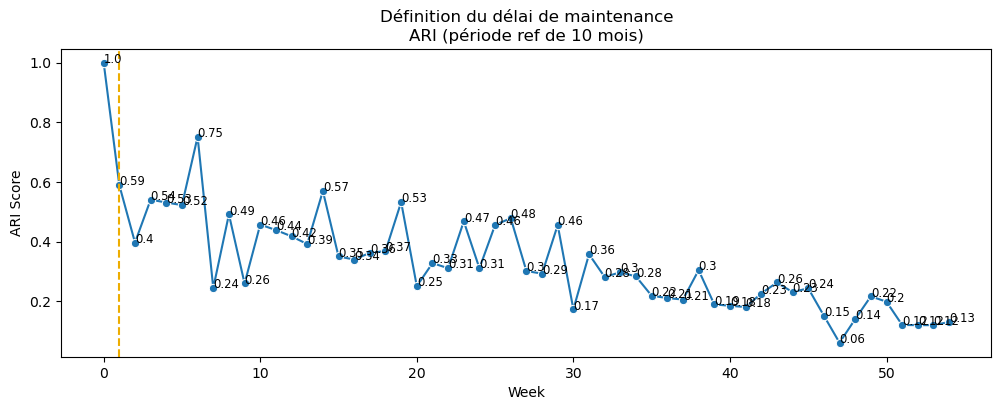

In [11]:
# Sélectionner le dernier point qui respecte le seuil de 0.80
last_point = ari_scores_df[ari_scores_df['ARI Score'] <= 0.80].iloc[0]['Week']

# Visualiser les résultats
plt.figure(figsize=(12, 4))
sns.lineplot(data=ari_scores_df, x="Week", y="ARI Score", marker='o')
plt.axvline(x=last_point, color='#EDAD01', linestyle='--')  # Ajouter une ligne verticale à x=last_point
plt.title("Définition du délai de maintenance\nARI (période ref de 10 mois)")
plt.xlabel("Week")
plt.ylabel("ARI Score")

# Ajouter des annotations
for i in range(len(ari_scores_df)):
    plt.text(ari_scores_df['Week'][i], ari_scores_df['ARI Score'][i], round(ari_scores_df['ARI Score'][i], 2), 
             horizontalalignment='left', size='small', color='black')

plt.show()

- ***Le graphique montre que les scores ARI diminuent rapidement après la période de référence de 10 mois, indiquant une perte de pertinence du modèle.***
****
- ***Pour maintenir une segmentation fiable, un réentraînement du modèle devrait être effectué toutes les 6 semaines, car c'est le point où les scores ARI commencent à chuter de manière significative en dessous de 0.8.***

In [12]:
# Sauvegarder les résultats
ari_scores_df.to_csv('ari_scores.csv', index=False)
print("Les scores ARI ont été sauvegardés dans ari_scores.csv")

Les scores ARI ont été sauvegardés dans ari_scores.csv


<h1 style="color: #1a1a1a; background-color: #e0f7fa; padding: 10px; border-radius: 5px;"> 4. Conclusion sur la nécessité de ré-entraîner le modèle</h1>

<font color='Blue'>**Ce notebook simule l'évolution des clusters sur une période de 10 mois, en évaluant la stabilité des segments à l'aide de l'Adjusted Rand Index (ARI).**</font>
*****
<font color='Blue'>**En suivant ces étapes, nous pouvons déterminer quand le modèle de clustering devient obsolète et nécessite un ré-entraînement.**